### Energy Consultation Analysis

***Please note: ***
Throughout the analysis, I am assuming this data comes from Enter's energy consultation 
(cf. Enter (2024), Foederservice,  https://www.enter.de/foerderservice)

In [23]:
#Data Manipulation libaries 

import pandas as pd
import numpy as np

#Data visualisation libraries

import matplotlib.pyplot as plt
import seaborn as sns

1) Data Preparation

Loading the datasets

In [24]:
orders_df = pd.read_csv('orders.csv', dtype= {'postal_code': str}) 
appointments_df = pd.read_csv('appointments.csv')


Converting datatypes

In [25]:
# Checking the datatypes of each column in orders_df
orders_df.dtypes

# Checking the datatypes of each column in appointments_df
appointments_df.dtypes

# Converting the datetime columns to datetime format
appointments_df['timestamp'] = pd.to_datetime(appointments_df['timestamp'], format='%d/%m/%Y %H:%M')
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], format='%d/%m/%Y %H:%M')


In [26]:
# Counting the number of rows in each dataset
appointments_count = appointments_df.shape[0]
orders_count = orders_df.shape[0]

# Calculating the percentage difference
percentage_difference = ((orders_count - appointments_count) / appointments_count) * 100

appointments_count, orders_count, percentage_difference

# -> There are 34240 entries more in appointments_df than there are in orders_df, showing a difference of ~60%

(56384, 22144, -60.726447219069236)

Identifaction of missing values

In [27]:
# Dropping null values in orders_df
orders_df.dropna(subset = ['postal_code'], inplace = True) #Null values are dropped to ensure the visuals are accurate

# Dropping null values in appointment_df
appointments_df['type'] = appointments_df['type'].str.strip()
appointments_df.dropna(subset=['customer_id'], inplace=True)
appointments_df.dropna(subset = ['type'], inplace = True) # Dropping null values to ensure the visuals are accurate and meaningful. 
appointments_df = appointments_df.loc[appointments_df['type']!='',:]

# Column Timestamp is not dropped for now as it may bias the analysis if analysed e.g. "How many clients did not finish until the final call appointment?"

print(appointments_df.isnull().sum())
print(orders_df.isnull().sum())

customer_id       0
timestamp      3412
type              0
dtype: int64
order_date      0
customer_id     0
postal_code     0
account_type    0
dtype: int64


Identification of duplicated values

In [28]:
# Checking for the number of unique customer IDs in appointment_df

appointments_df['customer_id'].nunique()
appointments_df['customer_id'].duplicated

<bound method Series.duplicated of 0        ff58fb3560
1        33dde97d25
2        3afa03aa1c
3        b823fbed0b
4        be0b8b0205
            ...    
56376    6c74178df3
56377    92a1193074
56379    d767f901b2
56382    6ce541e8ed
56383    2a0a2be849
Name: customer_id, Length: 53296, dtype: object>

In [29]:
# Calculating the number of unique customer_id values
unique_customer_id_count = appointments_df['customer_id'].nunique()
unique_timestamp_count = appointments_df['timestamp'].nunique()
unique_type_count = appointments_df['type'].nunique()

# Grouping by customer ID to check if every customer ID has a different timestamp (incl. date and time) and type pairs.
grouped_appointments_df = (appointments_df.groupby('customer_id').apply(lambda x: x[['timestamp', 'type']].shape[0]).reset_index(name='unique_count'))
grouped_appointments_df



C:\Users\Katha\AppData\Local\Temp\ipykernel_20676\843616958.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_appointments_df = (appointments_df.groupby('customer_id').apply(lambda x: x[['timestamp', 'type']].shape[0]).reset_index(name='unique_count'))


,customer_id,unique_count
0,0005cfd259,2
1,00089e61da,2
2,00164ae846,3
3,0018b37947,3
4,001ac46a49,3
...,...,...
19977,fff3178a0e,3
19978,fff36c43ce,1
19979,fff4b9927a,3
19980,fff981654d,3


In [30]:
#Validation: Matching if every the sum of the unique_counts matches the total number of customer ID in appointments_df

grouped_appointments_df['unique_count'].sum() == appointments_df['customer_id'].count()

np.True_

In [31]:
print(appointments_df['customer_id'].count())
print(orders_df['customer_id'].count())

53296
19930


2) Merging both dataframes

In [32]:
merged_df = pd.merge(appointments_df, orders_df , how = 'left', on = 'customer_id')
merged_df

,customer_id,timestamp,type,order_date,postal_code,account_type
0,ff58fb3560,2024-01-10 11:45:00,final_call,NaT,NaN,NaN
1,33dde97d25,2023-10-27 13:30:00,on_site_appointment,2023-09-20 00:00:00,73086,A
2,3afa03aa1c,2023-10-16 17:30:00,on_site_appointment,2023-09-19 00:00:00,79431,A
3,b823fbed0b,2023-12-11 08:15:00,project_call,2023-10-05 00:00:00,26272,A
4,be0b8b0205,2023-10-09 13:45:00,project_call,NaT,NaN,NaN
...,...,...,...,...,...,...
53291,6c74178df3,2023-12-08 16:15:00,final_call,2023-10-18 01:00:00,83425,A
53292,92a1193074,2023-12-07 10:45:00,project_call,2023-10-31 01:00:00,70253,A
53293,d767f901b2,2023-10-04 11:00:00,project_call,2023-09-18 03:00:00,84191,A
53294,6ce541e8ed,2023-10-24 09:30:00,on_site_appointment,2023-09-27 00:00:00,31114,A


3) Exploratory Data Analysis

3.1. Order Processing Analysis

Variable Definitions

***Order_date Definition***

order_df, column: "order_date"

1) order_date: Once the client shares the house data and documents digitally with Enter, the order is placed.

***Appointment Type Definition***

appointments_df, column: "type"

There are three different appointment types:

2) on_site_appointment: To create the renovation roadmap, the current state of the property is identified using a digital 3D model. Therefore, an on-site appointment is arranged.
3) project_call: The next step is a 60-minute detailed consultation call  with the client.
4) final_call: In order to receive the maximum subsidy, the savings of each measure are calculated and when they will be amortised. The renovation roadmap is discussed in the final call. The refurbishment roadmap is discussed during the final call.

***-> Please note: I am assuming this data comes from Enter's energy consultation (cf. Enter (2024), Foederservice,  https://www.enter.de/foerderservice) ***

In [33]:
#When an order is placed, how long does it take to have the first appointment?
# ->  What is the time difference between order_date and the on_site_appointment? 

# Creating column number_of_days_from_order_date to calculate the difference between the order placed and timestamp
merged_df['number_of_days_from_order_date'] = merged_df.apply(lambda row: (row['timestamp'] - row['order_date']).days, axis=1)
merged_df['number_of_days_from_order_date'] = merged_df['number_of_days_from_order_date'].astype('Int64')
merged_df.head()



,customer_id,timestamp,type,order_date,postal_code,account_type,number_of_days_from_order_date
0,ff58fb3560,2024-01-10 11:45:00,final_call,NaT,NaN,NaN,<NA>
1,33dde97d25,2023-10-27 13:30:00,on_site_appointment,2023-09-20,73086,A,37
2,3afa03aa1c,2023-10-16 17:30:00,on_site_appointment,2023-09-19,79431,A,27
3,b823fbed0b,2023-12-11 08:15:00,project_call,2023-10-05,26272,A,67
4,be0b8b0205,2023-10-09 13:45:00,project_call,NaT,NaN,NaN,<NA>


***When an order is placed, how many days does it take for each appointment type on average?*** 

In [34]:
#descriptive_stats = merged_df.groupby('type')['number_of_days_from_order_date'].describe()
#print(descriptive_stats)

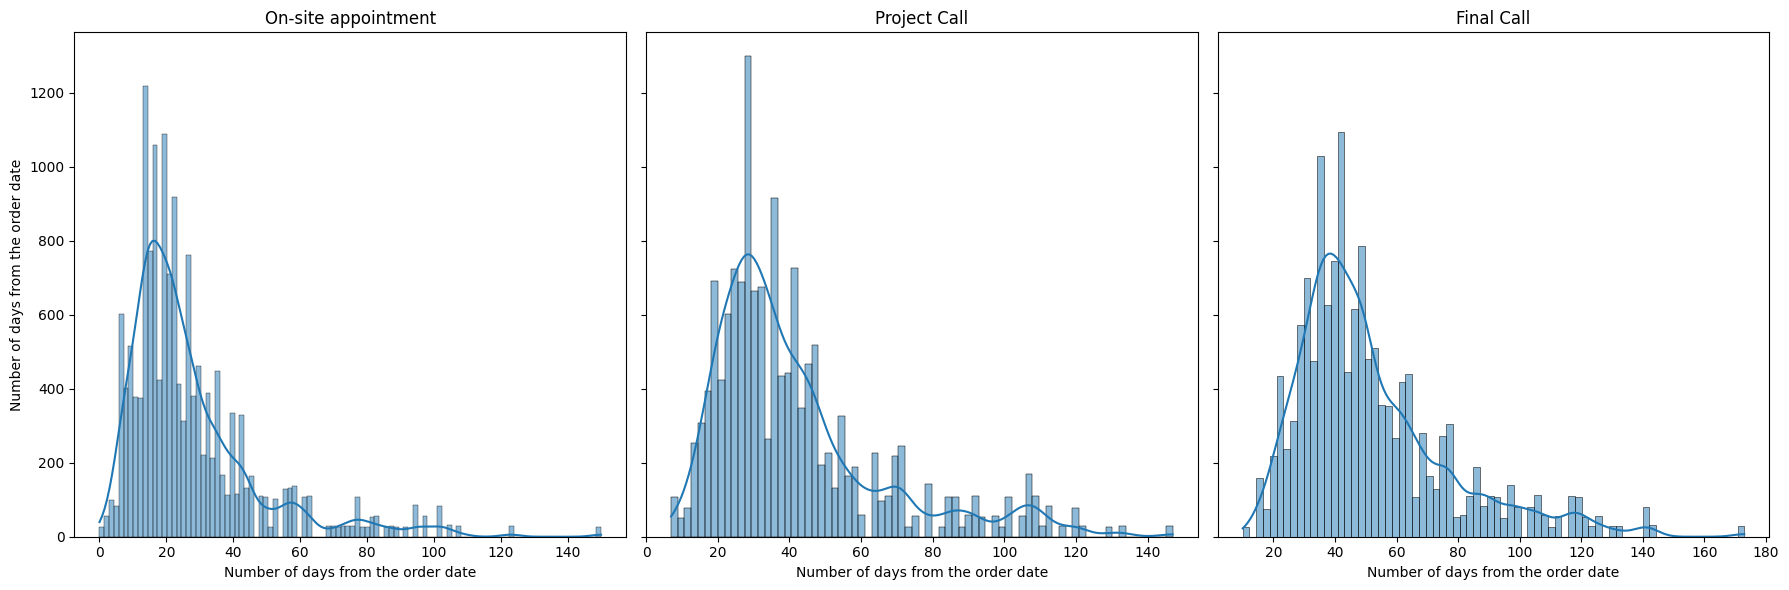

In [35]:
# Filting for each app. type

on_site_appointment = merged_df[merged_df['type'] == 'on_site_appointment']
project_call = merged_df[merged_df['type'] == 'project_call']
final_call = merged_df[merged_df['type'] == 'final_call']

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Creating the boxplots

sns.histplot(x='number_of_days_from_order_date', data=on_site_appointment, ax=axes[0], kde = True)
axes[0].set_title('On-site appointment')
axes[0].set_xlabel('Number of days from the order date')

sns.histplot(x='number_of_days_from_order_date', data=project_call, ax=axes[1], kde = True)
axes[1].set_title('Project Call')
axes[1].set_xlabel('Number of days from the order date')

sns.histplot(x='number_of_days_from_order_date', data=final_call, ax=axes[2], kde = True)
axes[2].set_title('Final Call')
axes[2].set_xlabel('Number of days from the order date')

# Setting common y-label
axes[0].set_ylabel('Number of days from the order date')

# Adjusting the layout
plt.tight_layout()
plt.show()

The Data Team analysed how long it takes to schedule different types of appointments after an order is placed by the client. 

(1) On-site Appointment

- Typical time until the on-site appointment: From the order date, most on-site appointments are scheduled within 21 days.
- Usual time range: Half of the appointments happen within 15 to 33 days.
- Delays: The average time is about 27 days. However, there are some cases where it takes up to 60 days or longer.

(2) Project Call

- Typical time until the on-site appointment: Most project calls are scheduled within 35 days from the order date.
- Usual time range: Half of the project calls take place within 26 to 49 days.
- Delays: The average time is about 42 days. Nevertheless, some project calls take much longer, exceeding 83 days in certain cases.

(3) Final Call

- Typical time until the on-site appointment: From the order date, most final calls are scheduled within 46 days.
- Usual time range: Half of the final calls are scheduled within 35 days to 62 days.
- Delays: The average time for a final call is about 52 days. There are some final calls taking over 102 days to schedule.

Why these insights are relevant to Enter:

- Project Planning: Having these timelines supports in planning the process , but also setting realistic expectations towards customers.
- Optimisation: Identifying and investigating delays can support to optimise the processes, but also to reduce scheduling times.

Potential next steps:

- Investigating delays: We could check for reasons for delays,  especially those appointments that take much longer than usual.
- Optimise schedulig: These data insights can support to streamline and optimise the scheduling processes to serve clients as best as possible.

***What is the proportion of each appointment type compared to the total appointments?***

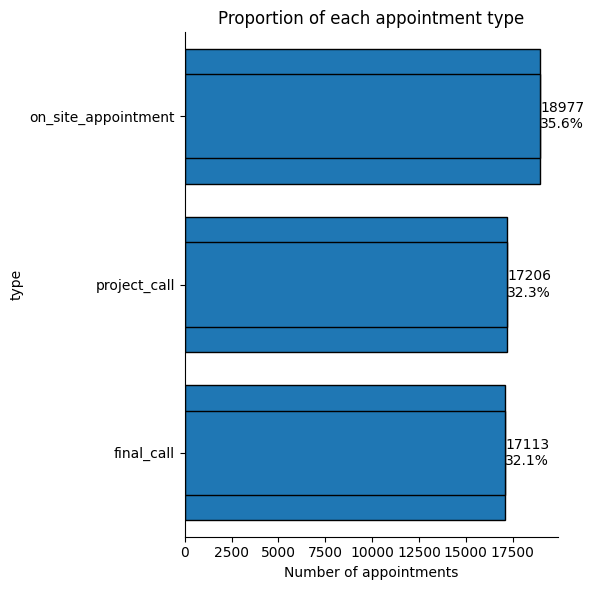

In [36]:
#What is the proportion of each appointment type?
value_counts_type = merged_df['type'].value_counts().sort_values()
#print(value_counts_type)

# What is the total number of appointments types?
total_appointments = merged_df['type'].count()
#print(total_appointments)

# Calculating the percentages for each appointment type
percentages = (value_counts_type / total_appointments) * 100

# Creating the bar chart to show the proportions of each type in percentage
plt.figure(figsize=(6, 6))
bars = plt.barh(value_counts_type.index, value_counts_type , edgecolor='black')

# Plotting the bar chart
ax = value_counts_type.plot(kind='barh', edgecolor='black', title='Proportion of each appointment type')

# Setting labels
ax.set_xlabel('Number of appointments')

# Annotate bars with count and percentage
labels = [f'{val}\n{percentages[index]:.1f}%' for index, val in value_counts_type.items()]
ax.bar_label(ax.containers[0], labels=labels, label_type='edge')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust layout to fit labels
plt.tight_layout()

# Show the plot
plt.show()

3.2. Regions by postal code analysis

3.2. is based on the following assumpions:
- There are postal codes that show four digits. I assume that the "0" was missing for (e.g. for places in Saxony starting with "0"). Therefore, those postal codes starting with a "0" are matching the other 5-digit postal codes.

In [37]:
#Handling all 4-digit postal codes and annotate a "0"

# Creating a function to format postal codes
def format_postal_code(postal_code):
    try:
        if np.isnan(float(postal_code)):
            return postal_code
        return postal_code.zfill(5)
    except ValueError:
        return postal_code.zfill(5)

# Apply formatting to the 'postal_code' column
merged_df['postal_code'] = merged_df['postal_code'].apply(format_postal_code)
merged_df.dropna(subset=['postal_code'], inplace=True)

# Display the updated DataFrame
print(merged_df['postal_code'])


1        73086
2        79431
3        26272
5        49515
6        64373
         ...  
53291    83425
53292    70253
53293    84191
53294    31114
53295    27525
Name: postal_code, Length: 47927, dtype: object


In [38]:
# Extracting the first digit of the postal code to group by region

merged_df['first_digit'] = merged_df['postal_code'].str[0]

# Ensure the new column is of type string
merged_df['first_digit'] = merged_df['first_digit'].astype(str)


In [39]:
# Calculating the average

region_descriptive_stats = merged_df.groupby('first_digit')['number_of_days_from_order_date'].describe()
#print(region_descriptive_stats)

***In which regions are most appointments types taking place?***

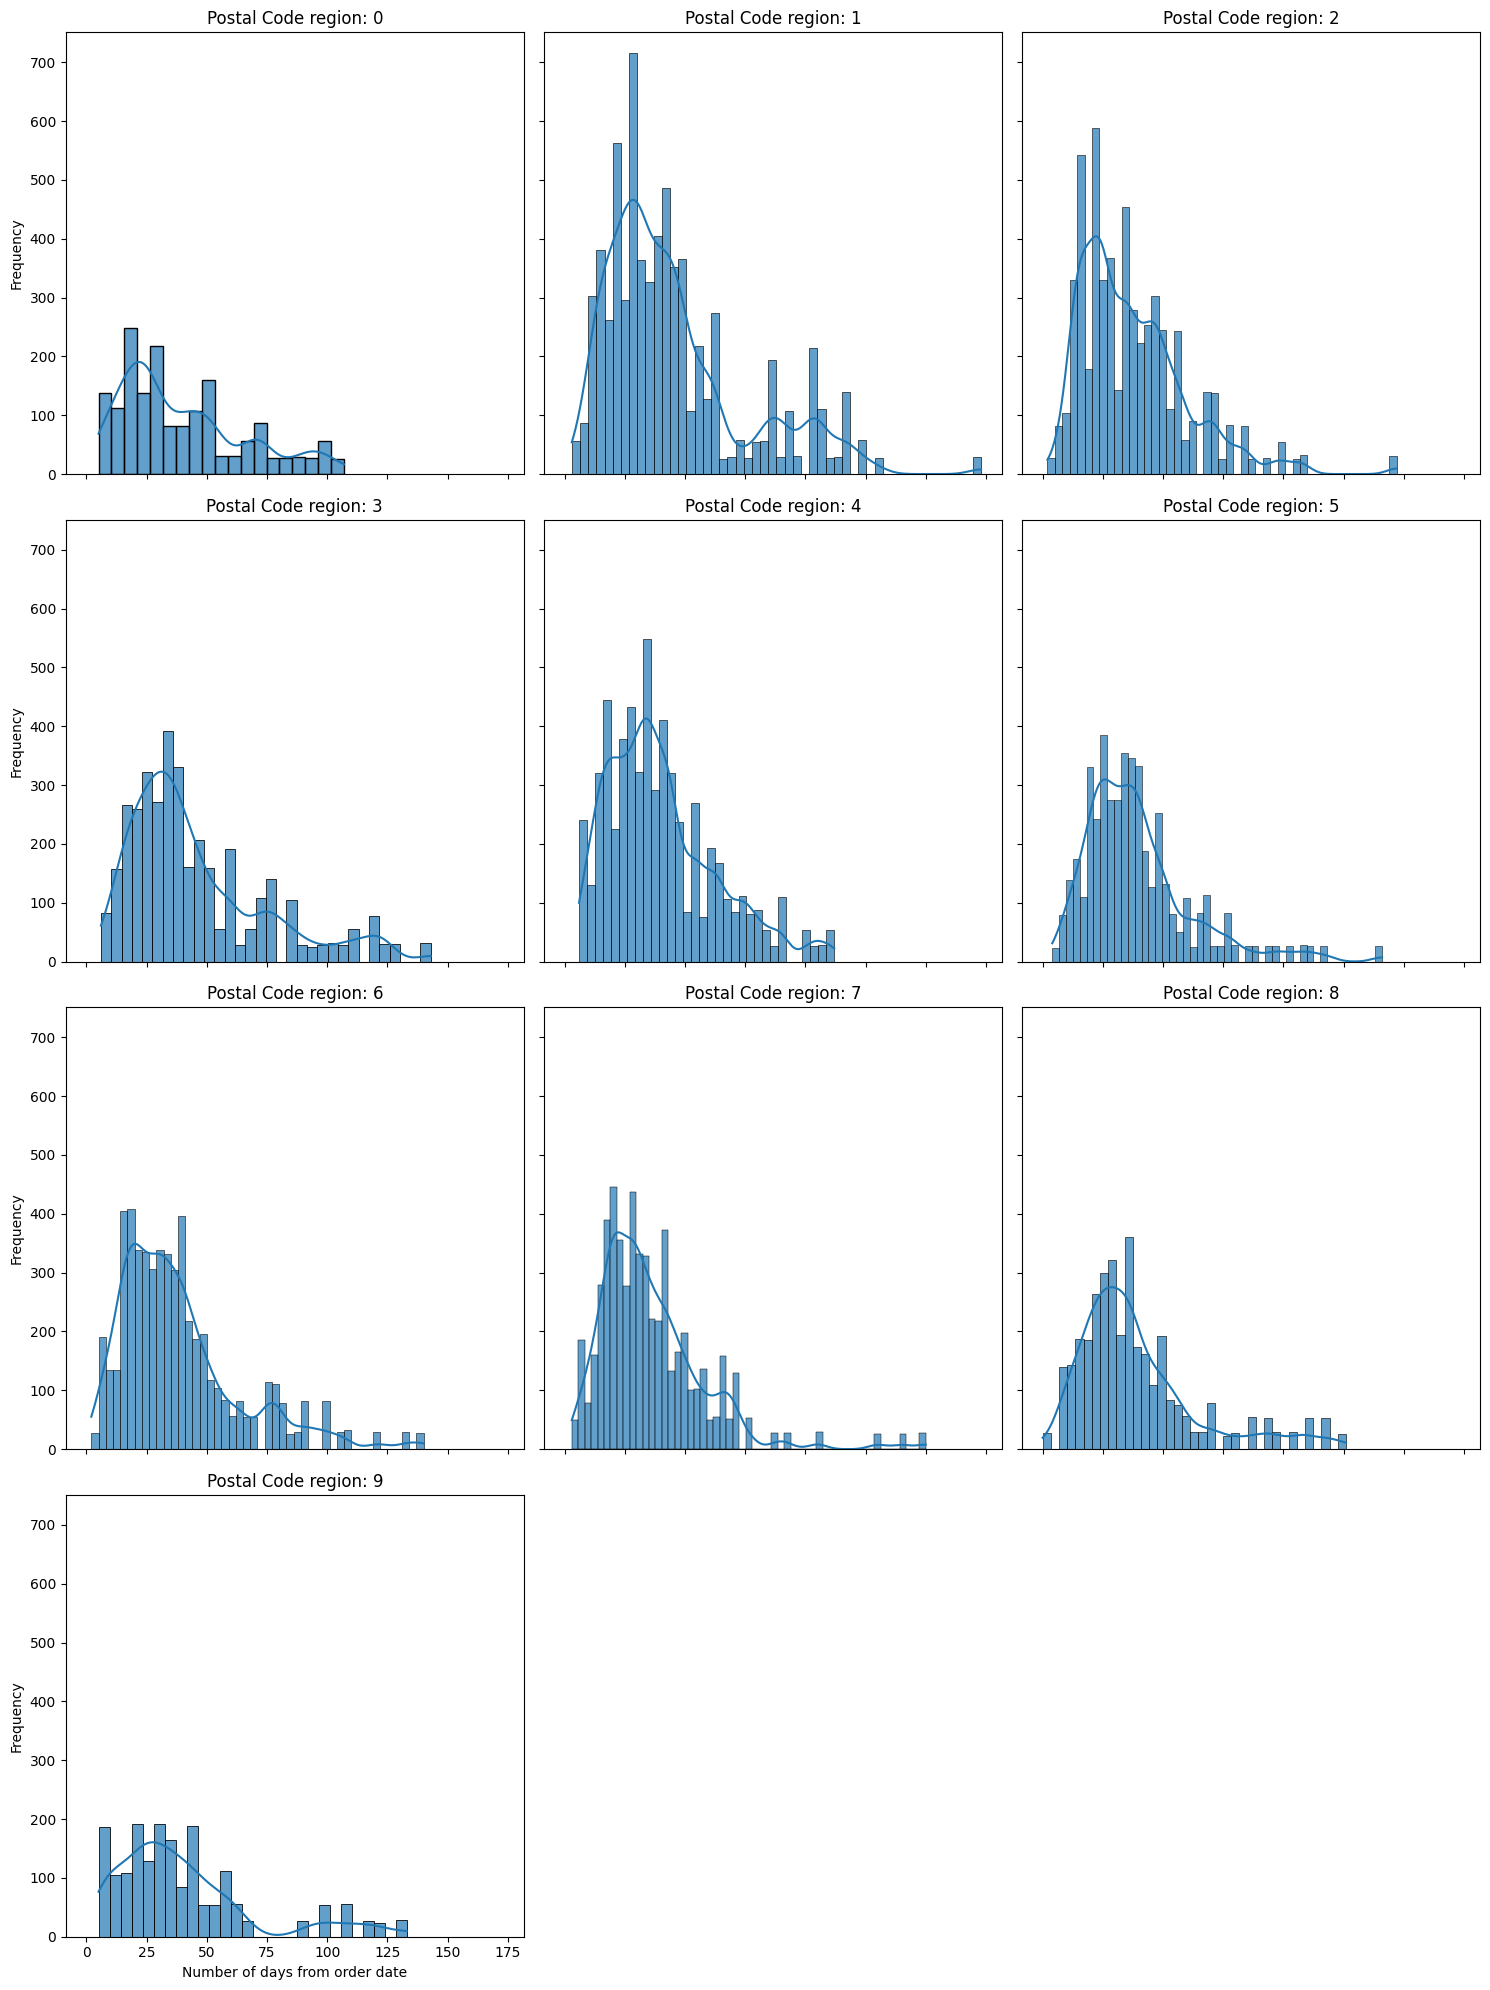

In [40]:
first_digits = sorted(merged_df['first_digit'].unique())

# Number of columns in the subplot grid
num_columns = 3
num_digits = len(first_digits)
num_rows = (num_digits + num_columns - 1) // num_columns  # Calculate the number of rows needed

# Setting up the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plotting a histogram  for each first digit of the postal code (region)
for i, digit in enumerate(first_digits):
    subset = merged_df[merged_df['first_digit'] == digit]
    sns.histplot(subset['number_of_days_from_order_date'], kde=True, ax=axes[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Postal Code region: {digit}')
    axes[i].set_xlabel('Number of days from order date')
    axes[i].set_ylabel('Frequency')

# Hiding  extra subplots if there are fewer digits than slots

for j in range(len(first_digits), len(axes)):
    fig.delaxes(axes[j])

# Adjusting layout to not overlap
plt.tight_layout()
plt.show()

Summary for each postal code area:

- Postal Code Area 0: On average, orders take about 34 days to process. Some are processed very quickly (0 days), while others take as long up to 173 days.
- Postal Code Area 1: The average is around 37 days. On the other hand, there are orders taking up to 173 days.
- Postal Code Area 2: Orders are processed in about 34 days on average. Most are processed within 2 to 147 days.
- Postal Code Area 3: On average, it takes about 36 days, with a wide range from 6 to 143 days.
- Postal Code Area 4: The average processing time is 35 days, with most orders falling between 6 and 112 days.
- Postal Code Area 5: Takes about 35 days on average, ranging from 4 to 141 days.
- Postal Code Area 6: Average processing time is 32 days, with a range from 2 to 140 days.
- Postal Code Area 7: Orders take an average of 31 days to process, with times ranging from 3 to 150 days.
- Postal Code Area 8: The average is 34 days, with a range from 0 to 126 days.
- Postal Code Area 9: On average, it takes about 34 days, ranging from 5 to 133 days.

In [41]:
region_descriptive_stats = merged_df.groupby(['first_digit', 'type'])['number_of_days_from_order_date'].describe()

# Print the results
#print(region_descriptive_stats)

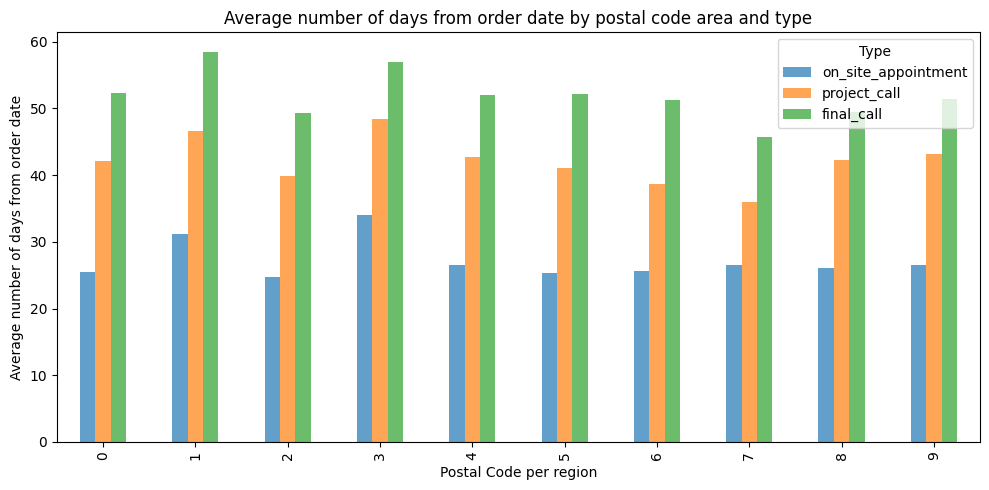

In [42]:
# Group by 'first_digit' and 'type', then calculate the mean of 'number_of_days_from_order_date'
mean_stats = merged_df.groupby(['first_digit', 'type'])['number_of_days_from_order_date'].mean().unstack()

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

#Ordering type
type_order = ['on_site_appointment', 'project_call', 'final_call']
mean_stats = mean_stats[type_order]

# Bar plot for average  number of days
mean_stats.plot(kind='bar', ax=ax, alpha=0.7)

# Adding labels and title to visual
ax.set_ylabel('Average number of days from order date')
ax.set_xlabel('Postal Code per region')
ax.set_title('Average number of days from order date by postal code area and type')
ax.legend(title='Type')

plt.tight_layout()
plt.show()

***What is the average number of days when an order is placed by postal code area and appointment type?***

1) On-Site Appointments:
- Shortest: In Region 2, on-site appointments are completed in around 19 days on average
- Longest: In Region 1, on-site appointments take on average 23 days. 
2) Project Calls:
- Shortest: In Region 7, project calls are completed in about 31 days.
- Longest: In Region 2, project calls take about 35 days to complete.
3) Final Calls:
- Shortest: In Region 8, final calls are completed in around 43 days.
- Longest: In Region 1, on average, final calls take about 49 days.

***Where are most orders placed?***
Region 1 shows highest number of orders. This region has a total of 6933 orders.